In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

### Feature stationarity

In [3]:
train_df = pd.read_csv('/Users/minqi/Documents/Kaggle/kaggle_hull_tactic_2025/train.csv')
features = train_df.drop(columns=['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']).columns.tolist()

<Axes: >

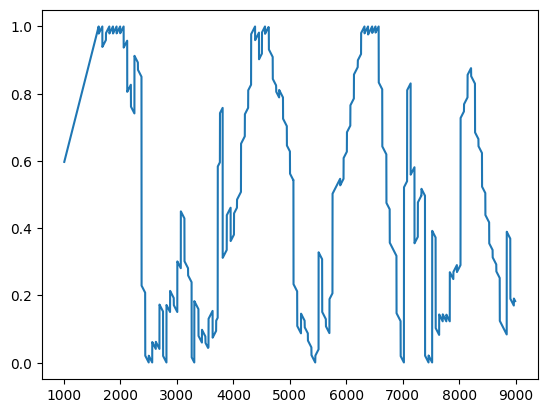

In [54]:
train_df['E10'].plot()

Rolling Std / Z-score Normalization

In [58]:
window = 12
feature_name = 'E10' 
rolling_mean = train_df[feature_name].dropna().rolling(window).mean()
rolling_std = train_df[feature_name].dropna().rolling(window).std()
stationalized = (train_df[feature_name].dropna() - rolling_mean) / rolling_std

<Axes: >

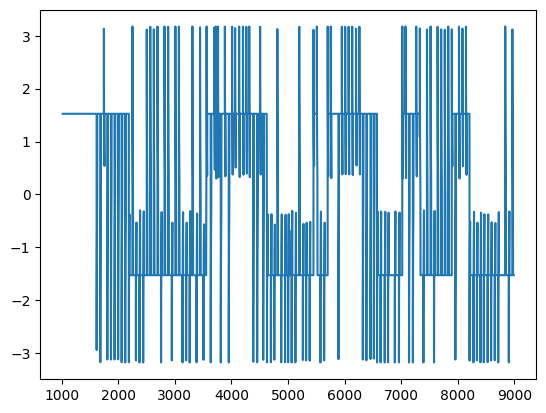

In [59]:
stationalized.plot()

In [ ]:
class TimeSeriesStationarizer:
    def __init__(self, df, window=12, signif=0.05):
        """
        df: pandas DataFrame of time series features (datetime index recommended)
        window: rolling window size for Z-score normalization
        signif: significance level for ADF test
        """
        self.df = df.copy()
        self.window = window
        self.signif = signif
        self.df_stationary = pd.DataFrame(index=df.index)
        self.results = pd.DataFrame(columns=['ADF_p_orig', 'Stationary_orig',
                                             'ADF_p_stn', 'Stationary_stn'])

    def adf_test(self, series):
        """
        Returns p-value and stationarity boolean
        """
        series = series.dropna()
        result = adfuller(series, autolag='AIC')
        p_value = result[1]
        stationary = p_value < self.signif
        return p_value, stationary

    def rolling_zscore(self, series):
        rolling_mean = series.rolling(window=self.window, min_periods=1).mean()
        rolling_std = series.rolling(window=self.window, min_periods=1).std()
        return (series - rolling_mean) / rolling_std

    def fit_transform(self):
        print(f"{'Feature':20s} | {'ADF p (orig)':12s} | {'Stationary?':10s} | {'ADF p (stn)':12s} | {'Stationary?'}")
        print("-"*80)
        
        for col in self.df.columns:
            p_orig, stationary_orig = self.adf_test(self.df[col])
            
            if stationary_orig:
                self.df_stationary[col] = self.df[col]
                p_stn, stationary_new = p_orig, stationary_orig
            else:
                self.df_stationary[col] = self.rolling_zscore(self.df[col])
                p_stn, stationary_new = self.adf_test(self.df_stationary[col])
            
            self.results.loc[col] = [p_orig, stationary_orig, p_stn, stationary_new]
            
            print(f"{col:20s} | {p_orig:<12.4f} | {str(stationary_orig):<10s} | {p_stn:<12.4f} | {stationary_new}")
        
        return self.df_stationary

# -----------------------------
# Example usage
# -----------------------------
# df = pd.read_csv("your_timeseries.csv", index_col=0, parse_dates=True)
# ts_stationarizer = TimeSeriesStationarizer(df, window=12)
# df_stationary = ts_stationarizer.fit_transform()
# print(ts_stationarizer.results)

In [ ]:
dummy_features = [col for col in train_df.columns if 'D' in col]
ts_stationarizer = TimeSeriesStationarizer(
    train_df[features].drop(columns=dummy_features),
    window=12
)
df_stationary = ts_stationarizer.fit_transform()
df_stationary = pd.concat([df_stationary, train_df[dummy_features]], axis=1)

E1                   | 0.0000       | True       | 0.0000       | True
E10                  | 0.1104       | False      | 0.0000       | True
E11                  | 0.0836       | False      | 0.0000       | True
E12                  | 0.4675       | False      | 0.0000       | True
E13                  | 0.0000       | True       | 0.0000       | True
E14                  | 0.0000       | True       | 0.0000       | True
E15                  | 0.0386       | True       | 0.0386       | True
E16                  | 0.0000       | True       | 0.0000       | True
E17                  | 0.0034       | True       | 0.0034       | True
E18                  | 0.0001       | True       | 0.0001       | True
E19                  | 0.0000       | True       | 0.0000       | True
E2                   | 0.1094       | False      | 0.0000       | True
E20                  | 0.2732       | False      | 0.0000       | True
E3                   | 0.0702       | False      | 0.0000       | True
E4    

In [73]:
df_stationary

,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,...,V9,D1,D2,D3,D4,D5,D6,D7,D8,D9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,1,1,0,0,0,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,1,1,0,0,0,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,1,0,0,0,0,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,1,0,0,0,0,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8985,1.565379,-1.525426,1.608723,1.608723,0.005952,0.005952,0.911376,-0.083496,-0.572447,0.223638,...,-0.649616,0,0,0,0,0,0,0,0,0
8986,1.562946,-1.525426,1.292477,1.292477,0.005622,0.005622,0.911706,-0.083542,-0.572080,0.222910,...,-0.668289,0,0,0,0,0,0,0,0,0
8987,1.560520,-1.525426,1.057111,1.057111,0.005291,0.005291,0.912037,-0.083874,-0.572016,0.222211,...,-0.670946,0,0,1,0,0,0,0,0,0
8988,1.558102,-1.525426,0.865309,0.865309,0.004960,0.004960,0.912368,-0.084206,-0.571952,0.221513,...,-0.646265,0,0,0,0,0,0,0,0,0


### Feature Imputation (used to produc train_imputed.csv)

In [4]:
def analyze_missing_values(df):
    """Comprehensive missing values analysis"""
    
    print("\n🕳️ MISSING VALUES ANALYSIS")
    print("="*50)
    
    # Overall missing statistics
    total_cells = df.shape[0] * df.shape[1]
    total_missing = df.isnull().sum().sum()
    missing_percentage = (total_missing / total_cells) * 100
    
    print(f"Total missing values: {total_missing:,} ({missing_percentage:.2f}% of all cells)")
    
    # Missing values per column
    missing_data = df.isnull().sum().sort_values(ascending=False)
    missing_data = missing_data[missing_data > 0]
    
    if len(missing_data) > 0:
        missing_percent = (missing_data / len(df)) * 100
        missing_df = pd.DataFrame({
            'Missing_Count': missing_data,
            'Missing_Percentage': missing_percent
        })
        
        print(f"\n📊 Top 20 columns with missing values:")
        display(missing_df.head(20))
        
        # Visualize missing values pattern
        if len(missing_data) > 0:
            fig, axes = plt.subplots(2, 2, figsize=(20, 12))
            
            # Missing values heatmap
            missing_matrix = df.isnull()
            sns.heatmap(missing_matrix.iloc[:, :50], cbar=True, ax=axes[0,0], cmap='viridis')
            axes[0,0].set_title('Missing Values Heatmap (First 50 Columns)')
            
            # Missing values bar chart
            top_missing = missing_df.head(20)
            top_missing['Missing_Percentage'].plot(kind='bar', ax=axes[0,1])
            axes[0,1].set_title('Top 20 Columns by Missing Percentage')
            axes[0,1].set_ylabel('Missing Percentage (%)')
            plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45)
            
            # Missing values over time
            if 'date_id' in df.columns:
                missing_by_date = df.groupby('date_id').apply(lambda x: x.isnull().sum().sum())
                axes[1,0].plot(missing_by_date.index, missing_by_date.values)
                axes[1,0].set_title('Missing Values Over Time')
                axes[1,0].set_xlabel('Date ID')
                axes[1,0].set_ylabel('Total Missing Values')
                
                # Missing percentage by date
                missing_pct_by_date = (missing_by_date / df.shape[1]) * 100
                axes[1,1].plot(missing_pct_by_date.index, missing_pct_by_date.values)
                axes[1,1].set_title('Missing Values Percentage Over Time')
                axes[1,1].set_xlabel('Date ID')
                axes[1,1].set_ylabel('Missing Percentage (%)')
            
            plt.tight_layout()
            plt.show()
    
    return missing_data




🕳️ MISSING VALUES ANALYSIS
Total missing values: 137,675 (15.63% of all cells)

📊 Top 20 columns with missing values:


,Missing_Count,Missing_Percentage
E7,6969,77.519466
V10,6049,67.285873
S3,5733,63.770857
M1,5547,61.701891
M13,5540,61.624027
M14,5540,61.624027
M6,5043,56.095662
V9,4539,50.489433
S12,3537,39.343715
M5,3283,36.518354


/var/folders/bt/4b3dr6ws7f92mwnjqkr28dg80000gn/T/ipykernel_11444/4294500320.py:46: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_date = df.groupby('date_id').apply(lambda x: x.isnull().sum().sum())


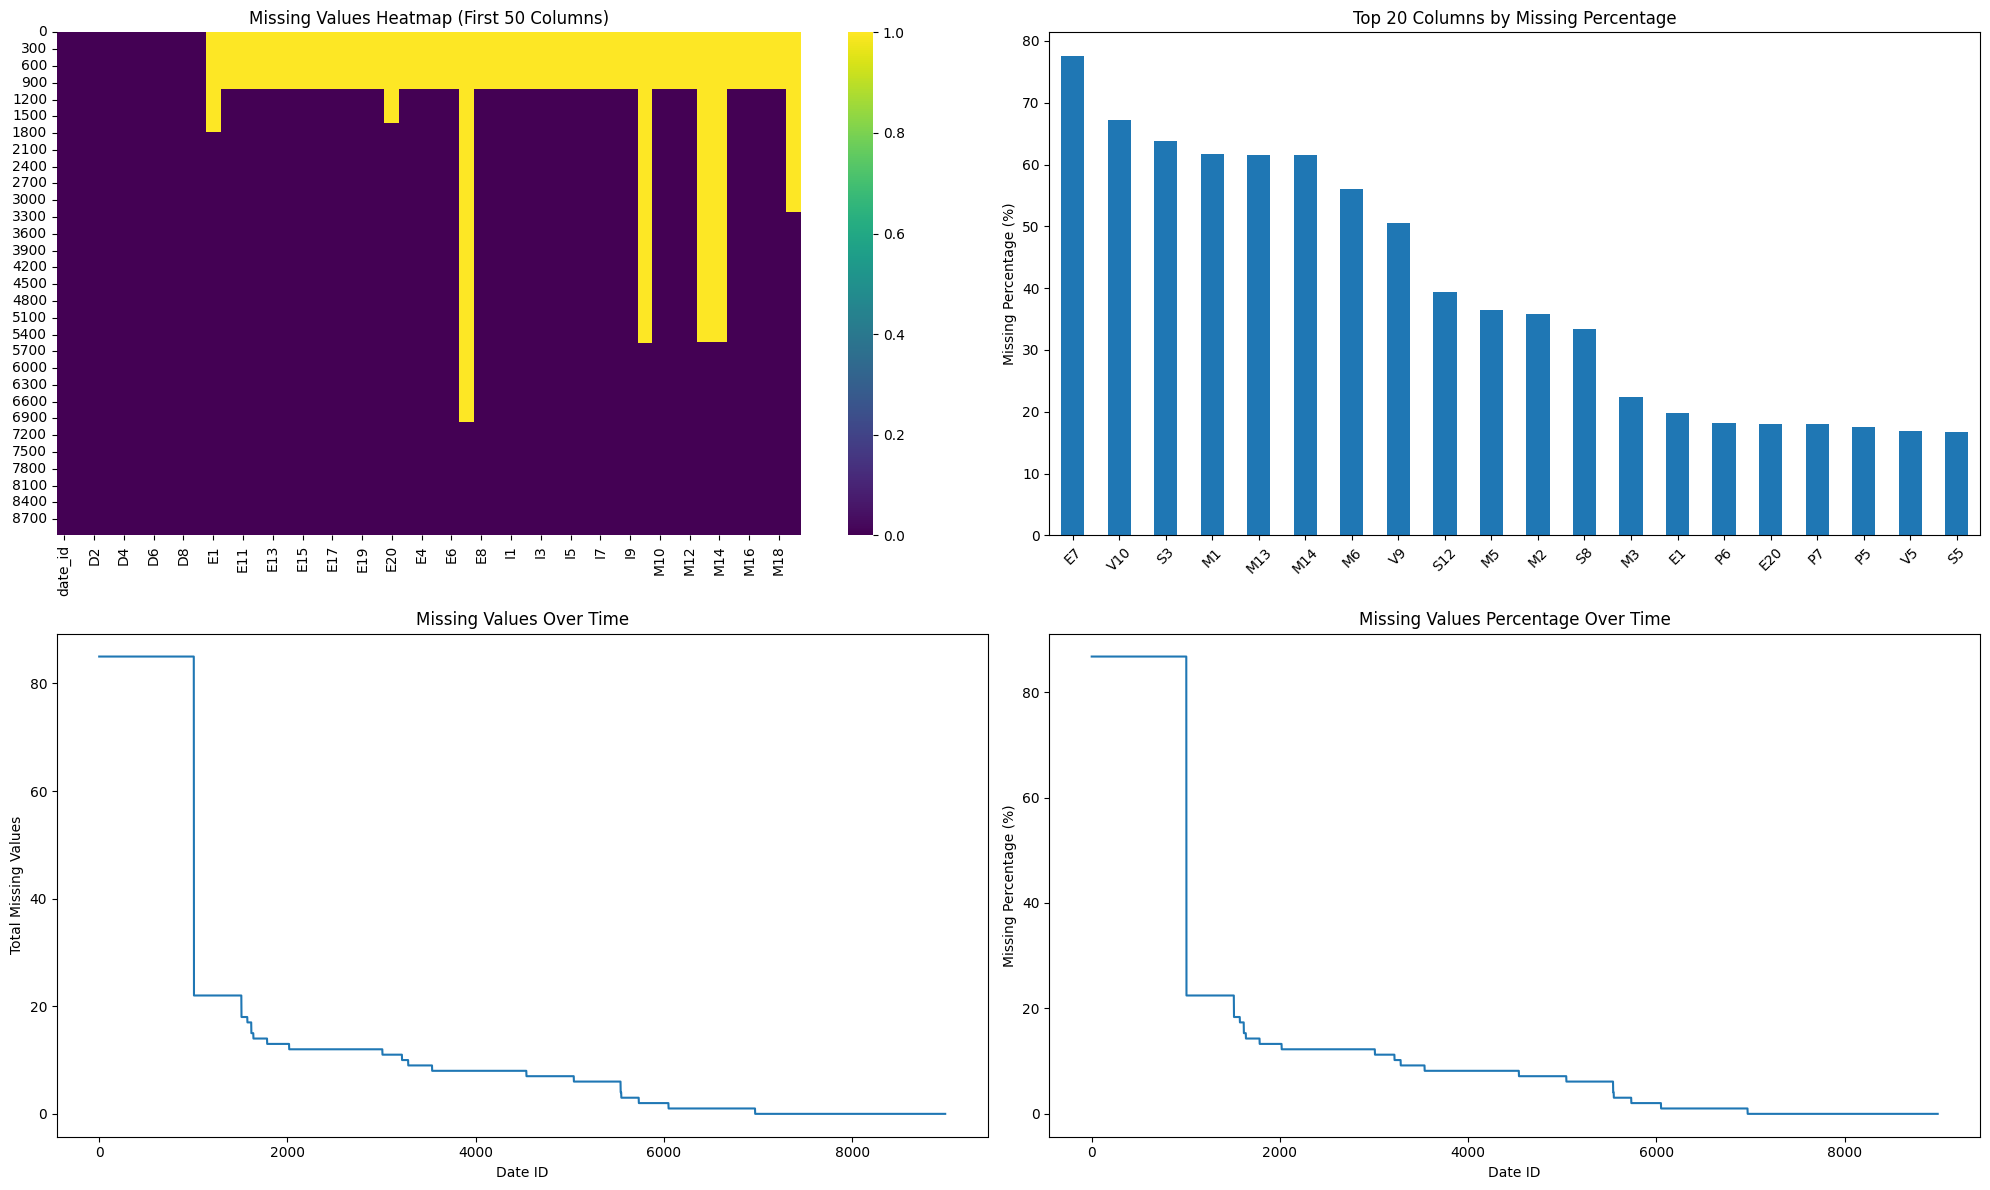

In [5]:
missing_analysis = analyze_missing_values(train_df)

In [6]:
# try dropping features with > 30% missing
features_to_drop = missing_analysis[missing_analysis > (0.3 * len(train_df))].index.tolist()

In [9]:
features_to_drop

['E7', 'V10', 'S3', 'M1', 'M13', 'M14', 'M6', 'V9', 'S12', 'M5', 'M2', 'S8']

In [12]:
train_df_imputed = train_df.drop(columns=features_to_drop).dropna()

In [13]:
train_df_imputed

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V2,V3,V4,V5,V6,V7,V8,forward_returns,risk_free_rate,market_forward_excess_returns
2018,2018,0,0,0,1,0,-1,0,0,0,...,0.655423,0.815476,0.751323,1.467741,0.000661,3.548550,0.000661,-0.003001,0.000212,-0.003526
2019,2019,0,0,0,1,0,-1,0,0,0,...,0.634259,0.766534,0.753968,1.097433,0.000661,3.632840,0.000661,0.004015,0.000207,0.003494
2020,2020,0,0,0,1,0,-1,0,0,0,...,0.583995,0.750661,0.725529,0.928160,0.000661,3.372954,0.000661,0.019660,0.000206,0.019140
2021,2021,0,0,0,1,0,0,0,1,0,...,0.536376,0.853836,0.730159,0.874947,0.000661,2.757016,0.000661,0.015686,0.000208,0.015165
2022,2022,0,0,0,1,1,0,0,1,0,...,0.494709,0.852513,0.722222,1.317207,0.000661,2.163179,0.000661,-0.000644,0.000208,-0.001164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8985,8985,0,0,0,0,0,0,0,0,0,...,0.785053,0.469577,0.837963,1.226772,0.822751,-0.707361,0.142857,0.002457,0.000155,0.001990
8986,8986,0,0,0,0,0,0,0,0,0,...,0.767857,0.671958,0.837963,0.785877,0.805556,-0.715692,0.196098,0.002312,0.000156,0.001845
8987,8987,0,0,1,0,0,0,0,0,0,...,0.734127,0.481481,0.787698,0.834898,0.823413,-0.723949,0.133929,0.002891,0.000156,0.002424
8988,8988,0,0,0,0,0,0,0,0,0,...,0.695106,0.655423,0.783730,0.994026,0.851852,-0.684937,0.101852,0.008310,0.000156,0.007843


In [14]:
train_df_imputed.to_csv('train_imputed.csv', index=False)